# Organize data

This script accepts preprocessed nifti images and organizes the data for ISFC

## py conversion

In [1]:
#jupyter nbconvert --to python slurm_create-data_preproc.ipynb

## Imports 

In [30]:
import warnings
import sys  
import random
# import logging

import deepdish as dd
import numpy as np

import brainiak.eventseg.event
import nibabel as nib
import nilearn as nil
# Import a function from BrainIAK to simulate fMRI data
import brainiak.utils.fmrisim as sim  

from nilearn.input_data import NiftiMasker

import scipy.io
from scipy import stats
from scipy.stats import norm, zscore, pearsonr
from scipy.signal import gaussian, convolve

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches
import seaborn as sns 



from brainiak import image, io
from scipy.stats import stats
import nibabel as nib
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

from nilearn import datasets, plotting
from nilearn.input_data import NiftiSpheresMasker

from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.image import concat_imgs, resample_img, mean_img,index_img
from nilearn import image
from nilearn import masking
from nilearn.plotting import view_img
from nilearn.image import resample_to_img

from nilearn.image import concat_imgs, resample_img, mean_img
from nilearn.plotting import view_img

import numpy as np 
import os
import os.path
import scipy.io
import nibabel as nib
from nilearn.input_data import NiftiMasker
from nilearn.masking import compute_epi_mask, compute_brain_mask
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit
from copy import deepcopy

# Brainiak # 
from brainiak import image, io 
from brainiak.isc import (isc, isfc, bootstrap_isc, permutation_isc,
                          timeshift_isc, phaseshift_isc,
                          compute_summary_statistic)
from brainiak.io import load_boolean_mask, load_images
from statsmodels.stats.multitest import multipletests
from nilearn.plotting import (find_xyz_cut_coords,
                              plot_connectome,
                              plot_stat_map)
from scipy.spatial.distance import squareform
%matplotlib inline

In [3]:
from nilearn import datasets

In [4]:
random.seed(10)

## custom helper functions 

In [5]:
from utils_anal import load_epi_data

## directories 

In [6]:
top_dir = '/jukebox/graziano/coolCatIsaac/MEI'
data_dir = top_dir + "/data"
work_dir = data_dir + '/work'
mask_dir = work_dir + '/masks'
behav_dir = top_dir + '/data/behavioral'
rois_dir = data_dir + "/rois"
fmri_prep = data_dir + '/bids/derivatives/fmriprep'
conf_dir = work_dir + '/confs'
preproc_dir = work_dir + '/preproc'
isc_dir = work_dir + '/isc_dat'


## main vars 

In [20]:
### sub_list ###
"""

========================================================
===== ~~~ Summary ALL ~~~ ===== 
========================================================
Initially exclude: sub-001, sub-003, sub-011, sub-012, sub-014, sub-015, sub-029 (3+ runs still available tho)
Maybe exclude: sub-014, sub-024, sub-037 (No button presses)
Maybe exclude: sub-020, sub-022, sub-031
total exclude = 10


~~~~~~~ BEHAVIORAL ~~~~~~~~~~
~~~ Summary behavioral ~~~

========================================================
========================================================
No button presses: sub-014, sub-024, sub-037 

========================================================
========================================================
sub-003: Extra row observed for external, which was manually deleted. Should be fine to rerun -- i removed from bad_subs
    - current brushing: 87, TRUE: 88 for THREE runs. last run when there was an issue and scan had to be restarted
    - Scan 6 == 1 run of brushing
    - Scan 7 = 3 runs of brushing 
    - ** no idea when run 7 was started tho! will prolly need to throw out! For now we can process all
sub-014: NO internal OR external bpress, curious! ---should be fixed now
    - changed excel data to include two null columns
    - ALSO only 30 TRs for the second run epi data. i went into the room to adjust runny eyes. Data for this run is not usable. but after should
      be okay if u want to put in the effort 
sub-015: less than 24 runs ---should be fixed now w custom code (but keep out of main run cuz will throw an error otherwise )
    - SUMMARY: need to exclude the office run 3 for fMRI but can include run 3 in behavioral, no data at all for CAKE
    - DID NOT add the 'mov_name' component to the custom code, will need to implment from current iteration
    - **** Use external, ignore internal for now... cuz internal is fuqd. Can preprocess all 7 tho

~~~~~~~ FMRI ~~~~~~~~~~
~~~ Summary fMRI ~~~
sub002: 
 - appended two TRs onto the last run, copied from the third to last TR. should be good to use
sub-003, sub-012, sub-014, sub-015, sub-029: 
 - Five runs usable, will need to incorporate them at some point 
sub-001: external usable - first three runs 

========================================================
========================================================
subject 002: (usable, with adjustment)
    only has 92 INSTEAD OF 94 TRs for the FINAL run of shrek. i think cuz i turned off the scanner
    too soon, which didn't account for 4 TRs of buffer? Yep! end tr is 390, (388, 112179). so duplicate TRs maybe.
    - Temporarily eliminate! or duplicate TRs 
    
sub-003: (usable, 5 runs)
- Scan 6 == 1 run of brushing
- Scan 7 = 3 runs of brushing 
*** need to re-preprocess, then append 6 and 7 together; or just throw out this one cuz idk when scan started

sub-011: (usable)
- not preprocessed 
sub-012 (5 runs usable, one run idk)
- I'll need to post process. It seems that an earbud fell out while reading the directions for run 5 
summary: the fifth run  needs to be discarded. all others are usable.
see the behav data: 
sub_dic['External']['oragami']
{'run-1': {'start_tr': 94, 'end_tr': 188, 'bpress': -1},
 'run-2': {'start_tr': 188, 'end_tr': 282, 'bpress': [100.81657150003593]},
 'run-3': {'start_tr': 282, 'end_tr': 376, 'bpress': [88.26579949003644]},
 'run-4': {'start_tr': 378,
  'end_tr': 472,
  }
- you can see taht the start TR is 94!! that's becuz i had to go into the scan room during the instructions screen.
- this is producing the wrong indexing -- becuz the scan doesn't contain enough TRs according to the behavioral data:
    - run 4 of shrek only has 12 TRs because we start at TR 94.
- im not sure when the scan actually started, but if i wanted to try to include i could 
    set the start TR to 1 -- essentially suggesting that the first TR was collected on the external 'waiting 
    for TR' flip. might as well try at some point, but exclude for now
    - this would involve just subtracting 94 from all start end end TRs i think
See the excel behavioral file for further notes notes
this 

sub-014 - no button press data and 7 runs (5 runs usable, but no bpress)
    - same problem as above -- i went into the scanner room during the instructions period to wipe eyes
    {'run-1': {'start_tr': 237, 'end_tr': 323, 'bpress': -1},
     'run-2': {'start_tr': 329, 'end_tr': 415, 'bpress': -1},
     'run-3': {'start_tr': 417, 'end_tr': 503, 'bpress': -1},
     'run-4': {'start_tr': 509, 'end_tr': 595, 'bpress': -1}}

sub-029: (5 runs usable)
- scanner malfunction, maybe possible to stitch together run 6 cuz i started on the *tenth* TR

========================================================
========================================================
Left handed: (sub-020, sub-022, sub-032)
    - sub-020: also no button presses, appeared to be awake tho
    - sub-022: lefty
    - sub-031: ambidexterious, great data
========================================================
========================================================
"""

## NON-ANOMALY sublist 
sub_list = [
    'sub-002', 'sub-004', 'sub-005','sub-006','sub-007','sub-008','sub-009','sub-010',
    'sub-013','sub-016','sub-017','sub-018','sub-019','sub-020','sub-021',
    'sub-022','sub-023','sub-024','sub-025','sub-026','sub-027','sub-028','sub-030','sub-031','sub-032',
    'sub-033','sub-034','sub-035','sub-036','sub-037','sub-038','sub-039','sub-040'
]
## ALL sublist
sub_list = [
    'sub-002', 'sub-003', 'sub-004', 'sub-005','sub-006','sub-007','sub-008','sub-009','sub-010', 'sub-012',
    'sub-013','sub-014', 'sub-015', 'sub-016','sub-017','sub-018','sub-019','sub-020','sub-021',
    'sub-022','sub-023','sub-024','sub-025','sub-026','sub-027','sub-028', 'sub-029', 'sub-030','sub-031','sub-032',
    'sub-033','sub-034','sub-035','sub-036','sub-037','sub-038','sub-039','sub-040', 'sub-041'
]

###### LOADING VARS #######




In [8]:
## TR length of each movie ## 
## INCLUDES 4 TRs from the countdown period -- but not the four TR buffer ##
mov_len_dic = {
'oragami' :  82,
'shrek' : 90,
'sherlock' : 98,
'brushing' : 88,
'cake' : 99,
'office' : 102    
}

## number of voxels
voxel_num = 112179

## load sub inc 
sub_run_inc = np.load(behav_dir + '/sub_run_inc.npy', allow_pickle = True).item()

In [9]:
"""
4 TRs were automatically added to the behavioral file. 
The mov_len_dic does NOT account for the four TRs at the end of the 'end_tr' ;
but it does have the four TRs from the countdown included on the front of the movie
So we basically need to:
  1) trim the first 4 TRs from the EPI data
  2) add 4 TRs to the mov_len_dic
  3) these operations basically cancel out



"""
## how many TRs on the end? (4  currently derived from the behavioral file
tr_buffer = 4 

# cuttoff the countdown 
trim_start = 4 # cuts off first 4 TRs

## how many parcels
num_parc = 400

"""
Currently end_TR adds 3 TRs following the end of the movie. The behavioral script adjusts 4 TRs; then the 
slice argument shaves off one TR
tr_buffer: in the behavioral data, we added 4 extra TRs to the movie length. The behavioral check justs accounts for this (idk what im saying)
"""

'\nCurrently end_TR adds 3 TRs following the end of the movie. The behavioral script adjusts 4 TRs; then the \nslice argument shaves off one TR\ntr_buffer: in the behavioral data, we added 4 extra TRs to the movie length. The behavioral check justs accounts for this (idk what im saying)\n'

In [10]:
dataset = datasets.fetch_atlas_schaefer_2018(n_rois=num_parc)
atlas_filename = dataset.maps
labels = dataset.labels

print(f"Atlas ROIs are located in nifti image (4D) at: {atlas_filename}")

Atlas ROIs are located in nifti image (4D) at: /usr/people/isaacrc/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz


In [11]:
# Load  sample data for resampling
resamp_run = load_epi_data(fmri_prep, 'sub-007', 2, "MNI")
# Load parcellation
d = nib.load(atlas_filename)
atlas_nii = resample_to_img(d, resamp_run, interpolation='nearest')
# Get parcellation fdata
atlas_img = atlas_nii.get_fdata()
# paracellations scheme
print(f'count parc:{len(np.unique(atlas_nii.get_fdata()))}')
print("shape of atlas nii object", atlas_img.shape)

Loading data from /jukebox/graziano/coolCatIsaac/MEI/data/bids/derivatives/fmriprep/sub-007/ses-01/func/sub-007_ses-01_task-None_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
shape of run 2 is (78, 93, 65, 369) 

count parc:401
shape of atlas nii object (78, 93, 65)


In [21]:
external = {}
internal = {}

for sub in sub_list:
    ### fMRI load ###
    sub_dic_fmri = np.load(f'{preproc_dir}/{sub}_fwhm6_conf_4D.npy', allow_pickle=True).item()
    print(f'start {sub}')
    ## BEHAVIORAL ##
    sub_dic_behav = np.load(os.path.join(behav_dir, f'{sub}_behav.npy'), allow_pickle=True).item()
    
    # Create subject number 
    sub_num = int(sub[-3:])

    for epi_index in range(0, 6):
        # Add one to the index to create 1-6 runs
        epi_run = epi_index + 1
        
        # check if run is to be included 
        if not sub_run_inc[sub][epi_run]: continue

        # Get the movie name
        mov_name = sub_dic_behav['mov_order'][epi_index]

        # Create an empty array for the movie runs, append four TRs to account for the 4 trailing TRs, subtract
        # the quantity of TRs that we are trimming from the front 
        mov_runs = np.zeros((mov_len_dic[mov_name] + tr_buffer - trim_start, num_parc, 0))

        print(f'movie: {mov_name} with shape {mov_runs.shape}')

        # Get the fMRI run for the current epi_index
        fmri_run = sub_dic_fmri[epi_run]
        
        # Loop over movie repetitions (there are 4)
        for run in range(1, 5):
            # Is this an internal or external run?
            key = 'External' if (sub_num % 2 == 1 and epi_index < 3) or (sub_num % 2 == 0 and epi_index >= 3) else 'Internal'
            
            # Begin slicing #
            start_tr = sub_dic_behav[key][mov_name][f'run-{run:d}']['start_tr']
            end_tr = sub_dic_behav[key][mov_name][f'run-{run:d}']['end_tr']
            run_slice = index_img(fmri_run, slice(start_tr + trim_start, end_tr)) # end_tr incoroporates the 4 TR buffer
            print(f'fMRI shape: {run_slice.shape}')
            
            # BEHAV checks #
            assert mov_runs.shape[0] == mov_len_dic[mov_name] + tr_buffer - trim_start, f'behavioral ERROR: movie: {mov_name}, epi {epi_run}, run: {run}'

            # fMRI data check #
            assert run_slice.shape[3] == mov_runs.shape[0] + tr_buffer - trim_start, f'fMRI error! {run_slice.shape[3]} verse {mov_runs.shape[0] + tr_buffer - trim_start}'

            
            # Get parcels and create 2d 
            print(f'shape of image {run_slice.shape}')
            f_dat_2d = run_slice.get_fdata()
            
            # loop through all TRs and get mean of each voxel pattern #
            means = [np.mean(f_dat_2d[atlas_img == parcel, :], axis=0)
                            for parcel in np.unique(atlas_img)[1:]]
            print(f'shape of extracted means: {np.column_stack(means).shape}')
            
            # expand to three dimensions for stacking 
            mov_means = np.expand_dims(np.column_stack(means), 2)
            print(f'expand! {mov_means.shape}')

            # Stack the run slice with the mov_runs array
            mov_runs = np.dstack((mov_runs, mov_means))
            print(f'stacked! {mov_runs.shape}')
        
        # set outer loop #
        if key == 'External':
            target_dict = external
        else:
            target_dict = internal

        if mov_name not in target_dict:
            target_dict[mov_name] = mov_runs
        else:
            #mov_runs = np.expand_dims(mov_runs, 3)
            target_dict[mov_name] = np.dstack((target_dict[mov_name], mov_runs))
    print(f'\n subject {sub} finished \n')

            
print('done')
            
            
            
            
            
            

start sub-002
movie: shrek with shape (90, 400, 0)
fMRI shape: (78, 93, 65, 90)
shape of image (78, 93, 65, 90)
shape of extracted means: (90, 400)
expand! (90, 400, 1)
stacked! (90, 400, 1)
fMRI shape: (78, 93, 65, 90)
shape of image (78, 93, 65, 90)
shape of extracted means: (90, 400)
expand! (90, 400, 1)
stacked! (90, 400, 2)
fMRI shape: (78, 93, 65, 90)
shape of image (78, 93, 65, 90)
shape of extracted means: (90, 400)
expand! (90, 400, 1)
stacked! (90, 400, 3)
fMRI shape: (78, 93, 65, 90)
shape of image (78, 93, 65, 90)
shape of extracted means: (90, 400)
expand! (90, 400, 1)
stacked! (90, 400, 4)
movie: sherlock with shape (98, 400, 0)
fMRI shape: (78, 93, 65, 98)
shape of image (78, 93, 65, 98)
shape of extracted means: (98, 400)
expand! (98, 400, 1)
stacked! (98, 400, 1)
fMRI shape: (78, 93, 65, 98)
shape of image (78, 93, 65, 98)
shape of extracted means: (98, 400)
expand! (98, 400, 1)
stacked! (98, 400, 2)
fMRI shape: (78, 93, 65, 98)
shape of image (78, 93, 65, 98)
shape of

fMRI shape: (78, 93, 65, 102)
shape of image (78, 93, 65, 102)
shape of extracted means: (102, 400)
expand! (102, 400, 1)
stacked! (102, 400, 3)
fMRI shape: (78, 93, 65, 102)
shape of image (78, 93, 65, 102)
shape of extracted means: (102, 400)
expand! (102, 400, 1)
stacked! (102, 400, 4)
movie: shrek with shape (90, 400, 0)
fMRI shape: (78, 93, 65, 90)
shape of image (78, 93, 65, 90)
shape of extracted means: (90, 400)
expand! (90, 400, 1)
stacked! (90, 400, 1)
fMRI shape: (78, 93, 65, 90)
shape of image (78, 93, 65, 90)
shape of extracted means: (90, 400)
expand! (90, 400, 1)
stacked! (90, 400, 2)
fMRI shape: (78, 93, 65, 90)
shape of image (78, 93, 65, 90)
shape of extracted means: (90, 400)
expand! (90, 400, 1)
stacked! (90, 400, 3)
fMRI shape: (78, 93, 65, 90)
shape of image (78, 93, 65, 90)
shape of extracted means: (90, 400)
expand! (90, 400, 1)
stacked! (90, 400, 4)
movie: sherlock with shape (98, 400, 0)
fMRI shape: (78, 93, 65, 98)
shape of image (78, 93, 65, 98)
shape of ext

fMRI shape: (78, 93, 65, 102)
shape of image (78, 93, 65, 102)
shape of extracted means: (102, 400)
expand! (102, 400, 1)
stacked! (102, 400, 1)
fMRI shape: (78, 93, 65, 102)
shape of image (78, 93, 65, 102)
shape of extracted means: (102, 400)
expand! (102, 400, 1)
stacked! (102, 400, 2)
fMRI shape: (78, 93, 65, 102)
shape of image (78, 93, 65, 102)
shape of extracted means: (102, 400)
expand! (102, 400, 1)
stacked! (102, 400, 3)
fMRI shape: (78, 93, 65, 102)
shape of image (78, 93, 65, 102)
shape of extracted means: (102, 400)
expand! (102, 400, 1)
stacked! (102, 400, 4)
movie: brushing with shape (88, 400, 0)
fMRI shape: (78, 93, 65, 88)
shape of image (78, 93, 65, 88)
shape of extracted means: (88, 400)
expand! (88, 400, 1)
stacked! (88, 400, 1)
fMRI shape: (78, 93, 65, 88)
shape of image (78, 93, 65, 88)
shape of extracted means: (88, 400)
expand! (88, 400, 1)
stacked! (88, 400, 2)
fMRI shape: (78, 93, 65, 88)
shape of image (78, 93, 65, 88)
shape of extracted means: (88, 400)
exp

shape of extracted means: (98, 400)
expand! (98, 400, 1)
stacked! (98, 400, 3)
fMRI shape: (78, 93, 65, 98)
shape of image (78, 93, 65, 98)
shape of extracted means: (98, 400)
expand! (98, 400, 1)
stacked! (98, 400, 4)

 subject sub-008 finished 

start sub-009
movie: cake with shape (99, 400, 0)
fMRI shape: (78, 93, 65, 99)
shape of image (78, 93, 65, 99)
shape of extracted means: (99, 400)
expand! (99, 400, 1)
stacked! (99, 400, 1)
fMRI shape: (78, 93, 65, 99)
shape of image (78, 93, 65, 99)
shape of extracted means: (99, 400)
expand! (99, 400, 1)
stacked! (99, 400, 2)
fMRI shape: (78, 93, 65, 99)
shape of image (78, 93, 65, 99)
shape of extracted means: (99, 400)
expand! (99, 400, 1)
stacked! (99, 400, 3)
fMRI shape: (78, 93, 65, 99)
shape of image (78, 93, 65, 99)
shape of extracted means: (99, 400)
expand! (99, 400, 1)
stacked! (99, 400, 4)
movie: office with shape (102, 400, 0)
fMRI shape: (78, 93, 65, 102)
shape of image (78, 93, 65, 102)
shape of extracted means: (102, 400)
exp

shape of extracted means: (88, 400)
expand! (88, 400, 1)
stacked! (88, 400, 1)
fMRI shape: (78, 93, 65, 88)
shape of image (78, 93, 65, 88)
shape of extracted means: (88, 400)
expand! (88, 400, 1)
stacked! (88, 400, 2)
fMRI shape: (78, 93, 65, 88)
shape of image (78, 93, 65, 88)
shape of extracted means: (88, 400)
expand! (88, 400, 1)
stacked! (88, 400, 3)
fMRI shape: (78, 93, 65, 88)
shape of image (78, 93, 65, 88)
shape of extracted means: (88, 400)
expand! (88, 400, 1)
stacked! (88, 400, 4)
movie: office with shape (102, 400, 0)
fMRI shape: (78, 93, 65, 102)
shape of image (78, 93, 65, 102)
shape of extracted means: (102, 400)
expand! (102, 400, 1)
stacked! (102, 400, 1)
fMRI shape: (78, 93, 65, 102)
shape of image (78, 93, 65, 102)
shape of extracted means: (102, 400)
expand! (102, 400, 1)
stacked! (102, 400, 2)
fMRI shape: (78, 93, 65, 102)
shape of image (78, 93, 65, 102)
shape of extracted means: (102, 400)
expand! (102, 400, 1)
stacked! (102, 400, 3)
fMRI shape: (78, 93, 65, 10

fMRI shape: (78, 93, 65, 88)
shape of image (78, 93, 65, 88)
shape of extracted means: (88, 400)
expand! (88, 400, 1)
stacked! (88, 400, 4)
movie: office with shape (102, 400, 0)
fMRI shape: (78, 93, 65, 102)
shape of image (78, 93, 65, 102)
shape of extracted means: (102, 400)
expand! (102, 400, 1)
stacked! (102, 400, 1)
fMRI shape: (78, 93, 65, 102)
shape of image (78, 93, 65, 102)
shape of extracted means: (102, 400)
expand! (102, 400, 1)
stacked! (102, 400, 2)
fMRI shape: (78, 93, 65, 102)
shape of image (78, 93, 65, 102)
shape of extracted means: (102, 400)
expand! (102, 400, 1)
stacked! (102, 400, 3)
fMRI shape: (78, 93, 65, 102)
shape of image (78, 93, 65, 102)
shape of extracted means: (102, 400)
expand! (102, 400, 1)
stacked! (102, 400, 4)

 subject sub-014 finished 

start sub-015
movie: sherlock with shape (98, 400, 0)
fMRI shape: (78, 93, 65, 98)
shape of image (78, 93, 65, 98)
shape of extracted means: (98, 400)
expand! (98, 400, 1)
stacked! (98, 400, 1)
fMRI shape: (78, 9

shape of extracted means: (82, 400)
expand! (82, 400, 1)
stacked! (82, 400, 1)
fMRI shape: (78, 93, 65, 82)
shape of image (78, 93, 65, 82)
shape of extracted means: (82, 400)
expand! (82, 400, 1)
stacked! (82, 400, 2)
fMRI shape: (78, 93, 65, 82)
shape of image (78, 93, 65, 82)
shape of extracted means: (82, 400)
expand! (82, 400, 1)
stacked! (82, 400, 3)
fMRI shape: (78, 93, 65, 82)
shape of image (78, 93, 65, 82)
shape of extracted means: (82, 400)
expand! (82, 400, 1)
stacked! (82, 400, 4)
movie: shrek with shape (90, 400, 0)
fMRI shape: (78, 93, 65, 90)
shape of image (78, 93, 65, 90)
shape of extracted means: (90, 400)
expand! (90, 400, 1)
stacked! (90, 400, 1)
fMRI shape: (78, 93, 65, 90)
shape of image (78, 93, 65, 90)
shape of extracted means: (90, 400)
expand! (90, 400, 1)
stacked! (90, 400, 2)
fMRI shape: (78, 93, 65, 90)
shape of image (78, 93, 65, 90)
shape of extracted means: (90, 400)
expand! (90, 400, 1)
stacked! (90, 400, 3)
fMRI shape: (78, 93, 65, 90)
shape of image 

shape of extracted means: (99, 400)
expand! (99, 400, 1)
stacked! (99, 400, 4)
movie: office with shape (102, 400, 0)
fMRI shape: (78, 93, 65, 102)
shape of image (78, 93, 65, 102)
shape of extracted means: (102, 400)
expand! (102, 400, 1)
stacked! (102, 400, 1)
fMRI shape: (78, 93, 65, 102)
shape of image (78, 93, 65, 102)
shape of extracted means: (102, 400)
expand! (102, 400, 1)
stacked! (102, 400, 2)
fMRI shape: (78, 93, 65, 102)
shape of image (78, 93, 65, 102)
shape of extracted means: (102, 400)
expand! (102, 400, 1)
stacked! (102, 400, 3)
fMRI shape: (78, 93, 65, 102)
shape of image (78, 93, 65, 102)
shape of extracted means: (102, 400)
expand! (102, 400, 1)
stacked! (102, 400, 4)

 subject sub-019 finished 

start sub-020
movie: office with shape (102, 400, 0)
fMRI shape: (78, 93, 65, 102)
shape of image (78, 93, 65, 102)
shape of extracted means: (102, 400)
expand! (102, 400, 1)
stacked! (102, 400, 1)
fMRI shape: (78, 93, 65, 102)
shape of image (78, 93, 65, 102)
shape of ext

shape of extracted means: (98, 400)
expand! (98, 400, 1)
stacked! (98, 400, 2)
fMRI shape: (78, 93, 65, 98)
shape of image (78, 93, 65, 98)
shape of extracted means: (98, 400)
expand! (98, 400, 1)
stacked! (98, 400, 3)
fMRI shape: (78, 93, 65, 98)
shape of image (78, 93, 65, 98)
shape of extracted means: (98, 400)
expand! (98, 400, 1)
stacked! (98, 400, 4)
movie: shrek with shape (90, 400, 0)
fMRI shape: (78, 93, 65, 90)
shape of image (78, 93, 65, 90)
shape of extracted means: (90, 400)
expand! (90, 400, 1)
stacked! (90, 400, 1)
fMRI shape: (78, 93, 65, 90)
shape of image (78, 93, 65, 90)
shape of extracted means: (90, 400)
expand! (90, 400, 1)
stacked! (90, 400, 2)
fMRI shape: (78, 93, 65, 90)
shape of image (78, 93, 65, 90)
shape of extracted means: (90, 400)
expand! (90, 400, 1)
stacked! (90, 400, 3)
fMRI shape: (78, 93, 65, 90)
shape of image (78, 93, 65, 90)
shape of extracted means: (90, 400)
expand! (90, 400, 1)
stacked! (90, 400, 4)
movie: oragami with shape (82, 400, 0)
fMRI 

fMRI shape: (78, 93, 65, 102)
shape of image (78, 93, 65, 102)
shape of extracted means: (102, 400)
expand! (102, 400, 1)
stacked! (102, 400, 1)
fMRI shape: (78, 93, 65, 102)
shape of image (78, 93, 65, 102)
shape of extracted means: (102, 400)
expand! (102, 400, 1)
stacked! (102, 400, 2)
fMRI shape: (78, 93, 65, 102)
shape of image (78, 93, 65, 102)
shape of extracted means: (102, 400)
expand! (102, 400, 1)
stacked! (102, 400, 3)
fMRI shape: (78, 93, 65, 102)
shape of image (78, 93, 65, 102)
shape of extracted means: (102, 400)
expand! (102, 400, 1)
stacked! (102, 400, 4)
movie: sherlock with shape (98, 400, 0)
fMRI shape: (78, 93, 65, 98)
shape of image (78, 93, 65, 98)
shape of extracted means: (98, 400)
expand! (98, 400, 1)
stacked! (98, 400, 1)
fMRI shape: (78, 93, 65, 98)
shape of image (78, 93, 65, 98)
shape of extracted means: (98, 400)
expand! (98, 400, 1)
stacked! (98, 400, 2)
fMRI shape: (78, 93, 65, 98)
shape of image (78, 93, 65, 98)
shape of extracted means: (98, 400)
exp

shape of extracted means: (99, 400)
expand! (99, 400, 1)
stacked! (99, 400, 3)
fMRI shape: (78, 93, 65, 99)
shape of image (78, 93, 65, 99)
shape of extracted means: (99, 400)
expand! (99, 400, 1)
stacked! (99, 400, 4)
movie: brushing with shape (88, 400, 0)
fMRI shape: (78, 93, 65, 88)
shape of image (78, 93, 65, 88)
shape of extracted means: (88, 400)
expand! (88, 400, 1)
stacked! (88, 400, 1)
fMRI shape: (78, 93, 65, 88)
shape of image (78, 93, 65, 88)
shape of extracted means: (88, 400)
expand! (88, 400, 1)
stacked! (88, 400, 2)
fMRI shape: (78, 93, 65, 88)
shape of image (78, 93, 65, 88)
shape of extracted means: (88, 400)
expand! (88, 400, 1)
stacked! (88, 400, 3)
fMRI shape: (78, 93, 65, 88)
shape of image (78, 93, 65, 88)
shape of extracted means: (88, 400)
expand! (88, 400, 1)
stacked! (88, 400, 4)
movie: office with shape (102, 400, 0)
fMRI shape: (78, 93, 65, 102)
shape of image (78, 93, 65, 102)
shape of extracted means: (102, 400)
expand! (102, 400, 1)
stacked! (102, 400, 

shape of extracted means: (82, 400)
expand! (82, 400, 1)
stacked! (82, 400, 1)
fMRI shape: (78, 93, 65, 82)
shape of image (78, 93, 65, 82)
shape of extracted means: (82, 400)
expand! (82, 400, 1)
stacked! (82, 400, 2)
fMRI shape: (78, 93, 65, 82)
shape of image (78, 93, 65, 82)
shape of extracted means: (82, 400)
expand! (82, 400, 1)
stacked! (82, 400, 3)
fMRI shape: (78, 93, 65, 82)
shape of image (78, 93, 65, 82)
shape of extracted means: (82, 400)
expand! (82, 400, 1)
stacked! (82, 400, 4)

 subject sub-028 finished 

start sub-029
movie: brushing with shape (88, 400, 0)
fMRI shape: (78, 93, 65, 88)
shape of image (78, 93, 65, 88)
shape of extracted means: (88, 400)
expand! (88, 400, 1)
stacked! (88, 400, 1)
fMRI shape: (78, 93, 65, 88)
shape of image (78, 93, 65, 88)
shape of extracted means: (88, 400)
expand! (88, 400, 1)
stacked! (88, 400, 2)
fMRI shape: (78, 93, 65, 88)
shape of image (78, 93, 65, 88)
shape of extracted means: (88, 400)
expand! (88, 400, 1)
stacked! (88, 400, 3

shape of extracted means: (82, 400)
expand! (82, 400, 1)
stacked! (82, 400, 3)
fMRI shape: (78, 93, 65, 82)
shape of image (78, 93, 65, 82)
shape of extracted means: (82, 400)
expand! (82, 400, 1)
stacked! (82, 400, 4)
movie: shrek with shape (90, 400, 0)
fMRI shape: (78, 93, 65, 90)
shape of image (78, 93, 65, 90)
shape of extracted means: (90, 400)
expand! (90, 400, 1)
stacked! (90, 400, 1)
fMRI shape: (78, 93, 65, 90)
shape of image (78, 93, 65, 90)
shape of extracted means: (90, 400)
expand! (90, 400, 1)
stacked! (90, 400, 2)
fMRI shape: (78, 93, 65, 90)
shape of image (78, 93, 65, 90)
shape of extracted means: (90, 400)
expand! (90, 400, 1)
stacked! (90, 400, 3)
fMRI shape: (78, 93, 65, 90)
shape of image (78, 93, 65, 90)
shape of extracted means: (90, 400)
expand! (90, 400, 1)
stacked! (90, 400, 4)
movie: office with shape (102, 400, 0)
fMRI shape: (78, 93, 65, 102)
shape of image (78, 93, 65, 102)
shape of extracted means: (102, 400)
expand! (102, 400, 1)
stacked! (102, 400, 1)


shape of extracted means: (82, 400)
expand! (82, 400, 1)
stacked! (82, 400, 1)
fMRI shape: (78, 93, 65, 82)
shape of image (78, 93, 65, 82)
shape of extracted means: (82, 400)
expand! (82, 400, 1)
stacked! (82, 400, 2)
fMRI shape: (78, 93, 65, 82)
shape of image (78, 93, 65, 82)
shape of extracted means: (82, 400)
expand! (82, 400, 1)
stacked! (82, 400, 3)
fMRI shape: (78, 93, 65, 82)
shape of image (78, 93, 65, 82)
shape of extracted means: (82, 400)
expand! (82, 400, 1)
stacked! (82, 400, 4)
movie: shrek with shape (90, 400, 0)
fMRI shape: (78, 93, 65, 90)
shape of image (78, 93, 65, 90)
shape of extracted means: (90, 400)
expand! (90, 400, 1)
stacked! (90, 400, 1)
fMRI shape: (78, 93, 65, 90)
shape of image (78, 93, 65, 90)
shape of extracted means: (90, 400)
expand! (90, 400, 1)
stacked! (90, 400, 2)
fMRI shape: (78, 93, 65, 90)
shape of image (78, 93, 65, 90)
shape of extracted means: (90, 400)
expand! (90, 400, 1)
stacked! (90, 400, 3)
fMRI shape: (78, 93, 65, 90)
shape of image 

shape of extracted means: (99, 400)
expand! (99, 400, 1)
stacked! (99, 400, 4)
movie: office with shape (102, 400, 0)
fMRI shape: (78, 93, 65, 102)
shape of image (78, 93, 65, 102)
shape of extracted means: (102, 400)
expand! (102, 400, 1)
stacked! (102, 400, 1)
fMRI shape: (78, 93, 65, 102)
shape of image (78, 93, 65, 102)
shape of extracted means: (102, 400)
expand! (102, 400, 1)
stacked! (102, 400, 2)
fMRI shape: (78, 93, 65, 102)
shape of image (78, 93, 65, 102)
shape of extracted means: (102, 400)
expand! (102, 400, 1)
stacked! (102, 400, 3)
fMRI shape: (78, 93, 65, 102)
shape of image (78, 93, 65, 102)
shape of extracted means: (102, 400)
expand! (102, 400, 1)
stacked! (102, 400, 4)

 subject sub-035 finished 

start sub-036
movie: cake with shape (99, 400, 0)
fMRI shape: (78, 93, 65, 99)
shape of image (78, 93, 65, 99)
shape of extracted means: (99, 400)
expand! (99, 400, 1)
stacked! (99, 400, 1)
fMRI shape: (78, 93, 65, 99)
shape of image (78, 93, 65, 99)
shape of extracted mea

shape of extracted means: (82, 400)
expand! (82, 400, 1)
stacked! (82, 400, 2)
fMRI shape: (78, 93, 65, 82)
shape of image (78, 93, 65, 82)
shape of extracted means: (82, 400)
expand! (82, 400, 1)
stacked! (82, 400, 3)
fMRI shape: (78, 93, 65, 82)
shape of image (78, 93, 65, 82)
shape of extracted means: (82, 400)
expand! (82, 400, 1)
stacked! (82, 400, 4)
movie: shrek with shape (90, 400, 0)
fMRI shape: (78, 93, 65, 90)
shape of image (78, 93, 65, 90)
shape of extracted means: (90, 400)
expand! (90, 400, 1)
stacked! (90, 400, 1)
fMRI shape: (78, 93, 65, 90)
shape of image (78, 93, 65, 90)
shape of extracted means: (90, 400)
expand! (90, 400, 1)
stacked! (90, 400, 2)
fMRI shape: (78, 93, 65, 90)
shape of image (78, 93, 65, 90)
shape of extracted means: (90, 400)
expand! (90, 400, 1)
stacked! (90, 400, 3)
fMRI shape: (78, 93, 65, 90)
shape of image (78, 93, 65, 90)
shape of extracted means: (90, 400)
expand! (90, 400, 1)
stacked! (90, 400, 4)
movie: sherlock with shape (98, 400, 0)
fMRI

shape of extracted means: (99, 400)
expand! (99, 400, 1)
stacked! (99, 400, 4)
movie: brushing with shape (88, 400, 0)
fMRI shape: (78, 93, 65, 88)
shape of image (78, 93, 65, 88)
shape of extracted means: (88, 400)
expand! (88, 400, 1)
stacked! (88, 400, 1)
fMRI shape: (78, 93, 65, 88)
shape of image (78, 93, 65, 88)
shape of extracted means: (88, 400)
expand! (88, 400, 1)
stacked! (88, 400, 2)
fMRI shape: (78, 93, 65, 88)
shape of image (78, 93, 65, 88)
shape of extracted means: (88, 400)
expand! (88, 400, 1)
stacked! (88, 400, 3)
fMRI shape: (78, 93, 65, 88)
shape of image (78, 93, 65, 88)
shape of extracted means: (88, 400)
expand! (88, 400, 1)
stacked! (88, 400, 4)
movie: oragami with shape (82, 400, 0)
fMRI shape: (78, 93, 65, 82)
shape of image (78, 93, 65, 82)
shape of extracted means: (82, 400)
expand! (82, 400, 1)
stacked! (82, 400, 1)
fMRI shape: (78, 93, 65, 82)
shape of image (78, 93, 65, 82)
shape of extracted means: (82, 400)
expand! (82, 400, 1)
stacked! (82, 400, 2)
fM

In [205]:
epi_run

4

In [207]:
sub_dic_behav['mov_order']

['sherlock', 'shrek', 'oragami', 'office', 'brushing']

In [203]:
fmri_run.shape

(78, 93, 65, 431)

In [201]:
end_tr

112

In [202]:
end_tr - start_tr 

98

In [50]:
external['shrek'].shape

(94, 400, 4)

# Reshape Dictionary

In [9]:
# .transpose(0, 1, 3, 2)

In [22]:
def reshape_dictionary(data, num_repeats = 4):
    """
    purpose: create a 4d array sorted into x runs per subject
    input: dictionary of stacked subject data 
    output: 4d array sorted into runs
    """
    output_dict = {}
    for mov in data:
        print(f'{mov} size is {data[mov].shape}')
        dim_3 = num_repeats
        dim_4 = int(data[mov].shape[2] / num_repeats)
        
        if key not in output_dict:
            output_dict[mov] = data[mov].reshape(*data[mov].shape[:-1], dim_3, dim_4, order = 'F')
        
        print("Is the data correctly reshaped?",
              np.array_equal(data[mov][:, :, 4], output_dict[mov][:, :, 0, 1]))
        print(f'reshaped {output_dict[mov].shape}')
    print()
    return output_dict

    

In [23]:
ext_isc = reshape_dictionary(external)
int_isc = reshape_dictionary(internal)

office size is (102, 400, 76)
Is the data correctly reshaped? True
reshaped (102, 400, 4, 19)
cake size is (99, 400, 72)
Is the data correctly reshaped? True
reshaped (99, 400, 4, 18)
brushing size is (88, 400, 76)
Is the data correctly reshaped? True
reshaped (88, 400, 4, 19)
sherlock size is (98, 400, 80)
Is the data correctly reshaped? True
reshaped (98, 400, 4, 20)
oragami size is (82, 400, 80)
Is the data correctly reshaped? True
reshaped (82, 400, 4, 20)
shrek size is (90, 400, 76)
Is the data correctly reshaped? True
reshaped (90, 400, 4, 19)

shrek size is (90, 400, 76)
Is the data correctly reshaped? True
reshaped (90, 400, 4, 19)
sherlock size is (98, 400, 76)
Is the data correctly reshaped? True
reshaped (98, 400, 4, 19)
oragami size is (82, 400, 72)
Is the data correctly reshaped? True
reshaped (82, 400, 4, 18)
office size is (102, 400, 76)
Is the data correctly reshaped? True
reshaped (102, 400, 4, 19)
cake size is (99, 400, 76)
Is the data correctly reshaped? True
reshape

# isfc 

In [25]:
# Compute mean with Fisher z-transformation
def fisher_mean(correlation, axis=None):
    return np.tanh(np.mean(np.arctanh(correlation), axis=axis))

def shuffle_along_axis(a, axis):
    idx = np.random.rand(*a.shape).argsort(axis=axis)
    return np.take_along_axis(a,idx,axis=axis)

In [42]:
run = 1
movie = 'sherlock'
condition = 'External'

In [43]:
## mask image ##
ref_nii = nib.load(mask_dir + "/whole_b_bnk.nii.gz")
mask_img = load_boolean_mask(mask_dir + "/whole_b_bnk.nii.gz")

# Get coordinates of mask voxels in original image
mask_coords = np.where(mask_img)

In [44]:
# select movie and run from loaded data 
if condition == 'External': 
    target_dic = ext_isc
else:
    target_dic = int_isc
    
intact_parcels = target_dic[movie][...,run -1,:]
print(f'run {run} shape is: {intact_parcels.shape}')

# Create shuffled data
scram_parcels = shuffle_along_axis(intact_parcels, axis=0)

# Z-score time series for each voxel
#data = zscore(data, axis=0)

run 1 shape is: (98, 400, 20)


### WSFC 

In [169]:
# Compute within-subject functional connectivity for intact data
intact_fcs = fisher_mean([np.corrcoef(s) for s in intact_parcels.T],
                         axis=0)

# Compute within-subject functional connectivity for scrambled data
scram_fcs = fisher_mean([np.corrcoef(s) for s in scram_parcels.T],
                        axis=0)

/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in arctanh
  This is separate from the ipykernel package so we can avoid doing imports until


In [170]:
# Compute ISFC on intact data
intact_isfcs = isfc(intact_parcels, pairwise=False,
                    vectorize_isfcs=False,
                    summary_statistic='mean')

# Compute ISFC on scrambled data
scram_isfcs = isfc(scram_parcels, pairwise=False,
                   vectorize_isfcs=False,
                   summary_statistic='mean')

In [171]:
# Load in network labels
label_fn = 'brainiak-aperture-isc-data/Schaefer2018_400Parcels_17Networks_order.txt'
with open(label_fn) as f:
    networks = [' '.join((label.split('_')[1][0], label.split('_')[2]))
                for label in f.readlines()]
    
# Get sorted unique network labels
idxs = np.unique(networks, return_index=True)[1]
network_labels = [networks[idx] for idx in sorted(idxs)]

# Get middle index for each network for plotting
network_idxs = [int(np.median([i for i, n in enumerate(networks)
                                if n == network]))
                for network in network_labels]

### visualize

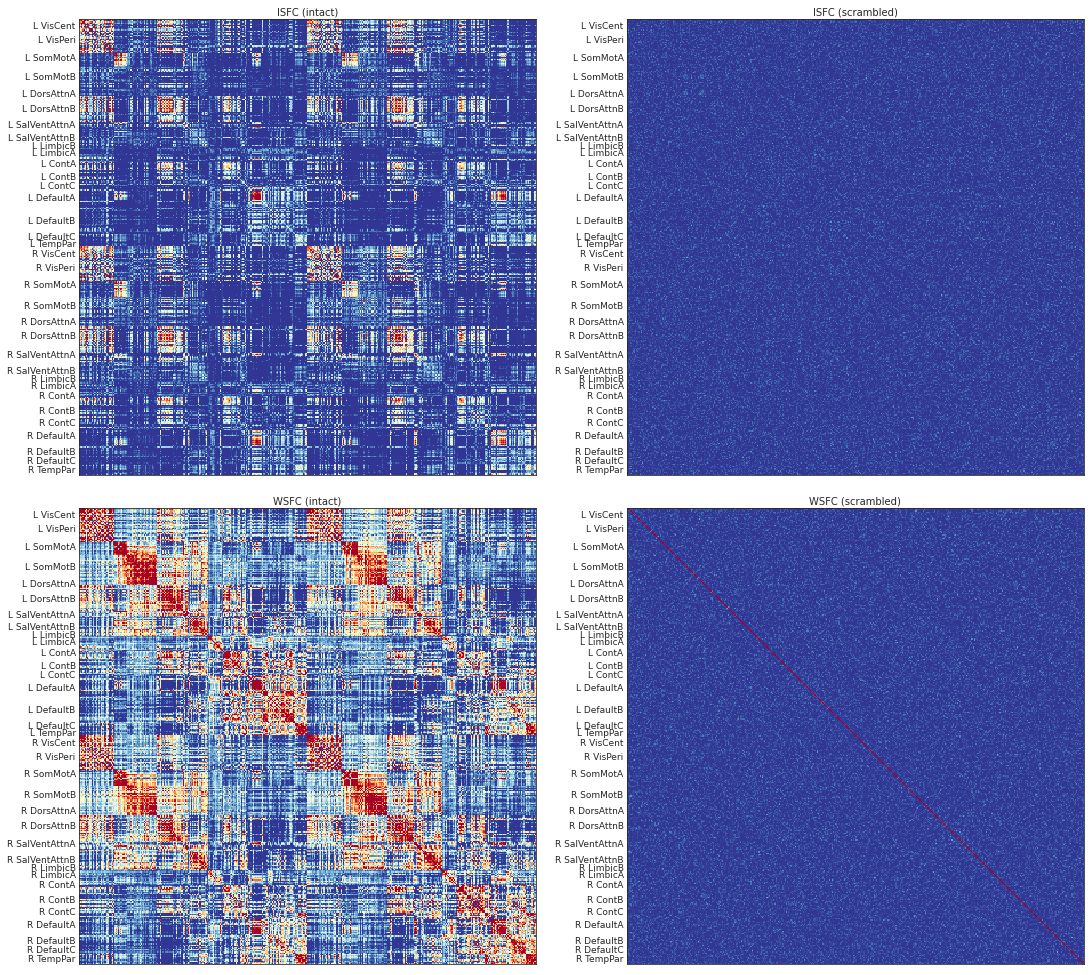

ISFC networks have generally lower correlations than within-subject functional connectivity, but better
differentiate intact and scrambled stories.

Correlation between intact and scrambled ISFC networks: 0.00252
Correlation between intact and scrambled WSFC networks: -0.000613


In [172]:
# Visualize ISFC/FC matrices for intact and scrambled conditions
vmin, vmax = 0, .5
sns.set_style('white')

fig, axs = plt.subplots(2, 2, figsize=(18, 18))
fc_mats = [intact_isfcs, scram_isfcs, intact_fcs, scram_fcs]
fc_titles = ['ISFC (intact)', 'ISFC (scrambled)',
             'WSFC (intact)', 'WSFC (scrambled)']
for ax, fc, t in zip(axs.flatten(), fc_mats, fc_titles):
    ax.matshow(fc, vmax=vmax, vmin=vmin, cmap='RdYlBu_r')
    ax.set_xlabel(t)
    ax.xaxis.set_label_position('top')
    ax.set_xticks([])
    ax.set_yticks(network_idxs)
    ax.set_yticklabels(network_labels)
    ax.tick_params(axis='y', which='both', length=0, labelsize=9)
plt.subplots_adjust(hspace=0)
plt.show()

# High correlation between intact and scrambled
# for within-subject functional connectivity
fc_r = pearsonr(squareform(intact_fcs, checks=False),
                squareform(scram_fcs, checks=False))[0]

# ISFC is more distinct for intact and scrambed conditions
isfc_r = pearsonr(squareform(intact_isfcs, checks=False),
                  squareform(scram_isfcs, checks=False))[0]

print("ISFC networks have generally lower correlations than "
      "within-subject functional connectivity, but better\n"
      "differentiate intact and scrambled stories.\n")
print(f"Correlation between intact and scrambled ISFC networks: {isfc_r:.3}")
print(f"Correlation between intact and scrambled WSFC networks: {fc_r:.3}")

# plot 1

In [45]:
# Compute ISFC on intact data
intact_isfcs = isfc(intact_parcels, pairwise=False,
                    vectorize_isfcs=False,
                    summary_statistic='mean')

In [40]:
# Load in network labels
label_fn = 'brainiak-aperture-isc-data/Schaefer2018_400Parcels_17Networks_order.txt'
with open(label_fn) as f:
    networks = [' '.join((label.split('_')[1][0], label.split('_')[2]))
                for label in f.readlines()]
    
# Get sorted unique network labels
idxs = np.unique(networks, return_index=True)[1]
network_labels = [networks[idx] for idx in sorted(idxs)]

# Get middle index for each network for plotting
network_idxs = [int(np.median([i for i, n in enumerate(networks)
                                if n == network]))
                for network in network_labels]

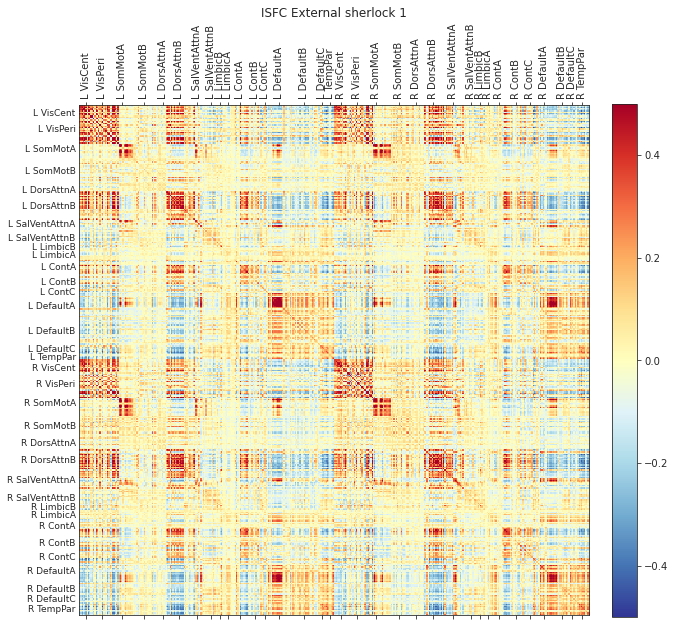

In [46]:
vmin, vmax = -.5, .5
sns.set_style('white')

fig, ax = plt.subplots(figsize=(10, 10))
fc_mat = intact_isfcs  # Choose the desired FC matrix to plot
fc_title = 'ISFC (intact)'  # Set the title accordingly

im = ax.matshow(fc_mat, vmax=vmax, vmin=vmin, cmap='RdYlBu_r')
ax.xaxis.set_label_position('bottom')

# Rotate xtick labels
ax.set_xticks(network_idxs)
ax.set_xticklabels(network_labels, rotation=90)  # Rotate the labels by 90 degrees

ax.set_yticks(network_idxs)
ax.set_yticklabels(network_labels)
ax.tick_params(axis='y', which='both', length=0, labelsize=9)
ax.set_title(f"ISFC {condition} {movie} {run}")

# Add color bar
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.show()

### Plot on glass brain 

In [176]:
# Find center-of-mass for each parcel in MNI space for visualization
node_coords = []
for parcel in np.unique(atlas_img)[1:]:
    parcel_img = atlas_img == parcel
    parcel_nii = nib.Nifti1Image(parcel_img, atlas_nii.affine,
                                 atlas_nii.header)
    node_coords.append(find_xyz_cut_coords(parcel_nii))

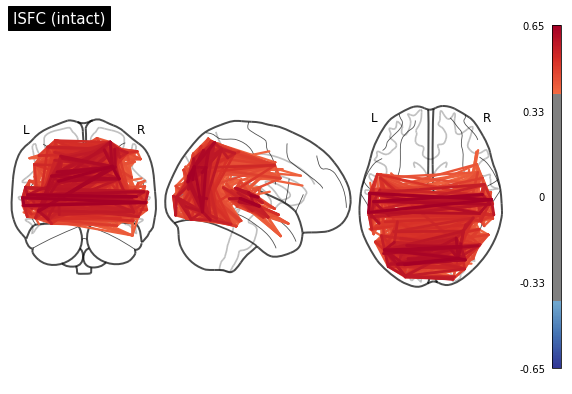

In [178]:
# Visualize WSFC and ISFC connectome on glass brain (takes a minute to render)
display_mode = 'ortho'
edge_threshold = .4
edge_vmin, edge_vmax = -.65, .65
edge_cmap='RdYlBu_r'

fc_mat = intact_isfcs  # Choose the desired FC matrix to plot
fc_title = 'ISFC (intact)'  # Set the title accordingly

fig, ax = plt.subplots(figsize=(10, 7))
plot_connectome(fc_mat, node_coords, node_size=0,
                edge_threshold=edge_threshold, 
                edge_vmin=edge_vmin, edge_vmax=edge_vmax,
                edge_cmap=edge_cmap, 
                display_mode=display_mode, 
                title=fc_title, axes=ax, colorbar=True)

plt.show()

In [182]:
node_coords[0]

[-32.32116788321167, -41.55109489051094, -21.521897810218974]

# Subtractions

In [47]:
run = 1
movie = 'sherlock'
run_1 = 4
run_2 = 1

In [115]:
## mask image ##
ref_nii = nib.load(mask_dir + "/whole_b_bnk.nii.gz")
mask_img = load_boolean_mask(mask_dir + "/whole_b_bnk.nii.gz")

# Get coordinates of mask voxels in original image
mask_coords = np.where(mask_img)

In [55]:
# select movie and run from loaded data 

## internal vs External
intact_parcels_1 = ext_isc[movie][...,run -1,:]
intact_parcels_2 = int_isc[movie][...,run -1,:]

## run 1 vs run 4
intact_parcels_1 = int_isc[movie][...,run_1 -1,:]
intact_parcels_2 = int_isc[movie][...,run_2 -1,:]

print(f'run {run} shape is: {intact_parcels_1.shape}')

# Create shuffled data
scram_parcels = shuffle_along_axis(intact_parcels_1, axis=0)

# Z-score time series for each voxel
#data = zscore(data, axis=0)

run 1 shape is: (98, 400, 19)


### WSFC 

In [56]:
# Compute within-subject functional connectivity for intact data
intact_fcs_1 = fisher_mean([np.corrcoef(s) for s in intact_parcels_1.T],
                         axis=0)

# Compute within-subject functional connectivity for intact data
intact_fcs_2 = fisher_mean([np.corrcoef(s) for s in intact_parcels_2.T],
                         axis=0)

# Compute within-subject functional connectivity for scrambled data
scram_fcs = fisher_mean([np.corrcoef(s) for s in scram_parcels.T],
                        axis=0)

/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in arctanh
  This is separate from the ipykernel package so we can avoid doing imports until


## Compute ISFC on intact data

In [57]:
# Compute ISFC on intact data
intact_isfcs_1 = isfc(intact_parcels_1, pairwise=False,
                    vectorize_isfcs=False,
                    summary_statistic='mean')

intact_isfcs_2 = isfc(intact_parcels_2, pairwise=False,
                    vectorize_isfcs=False,
                    summary_statistic='mean')

# Compute ISFC on scrambled data
scram_isfcs = isfc(scram_parcels, pairwise=False,
                   vectorize_isfcs=False,
                   summary_statistic='mean')


In [145]:
subtr_fcs = np.subtract(intact_fcs_1, intact_fcs_2)

In [58]:
subtr_isfcs = np.subtract(intact_isfcs_1, intact_isfcs_2)

In [138]:
internal_1v4 = subtr_isfcs
#external_1v4 = subtr_isfcs
double_dif = np.subtract(external_1v4, internal_1v4)

In [53]:
subtr_isfcs.shape

(400, 400)

In [50]:
# Load in network labels
label_fn = 'brainiak-aperture-isc-data/Schaefer2018_400Parcels_17Networks_order.txt'
with open(label_fn) as f:
    networks = [' '.join((label.split('_')[1][0], label.split('_')[2]))
                for label in f.readlines()]
    
# Get sorted unique network labels
idxs = np.unique(networks, return_index=True)[1]
network_labels = [networks[idx] for idx in sorted(idxs)]

# Get middle index for each network for plotting
network_idxs = [int(np.median([i for i, n in enumerate(networks)
                                if n == network]))
                for network in network_labels]

### visualize

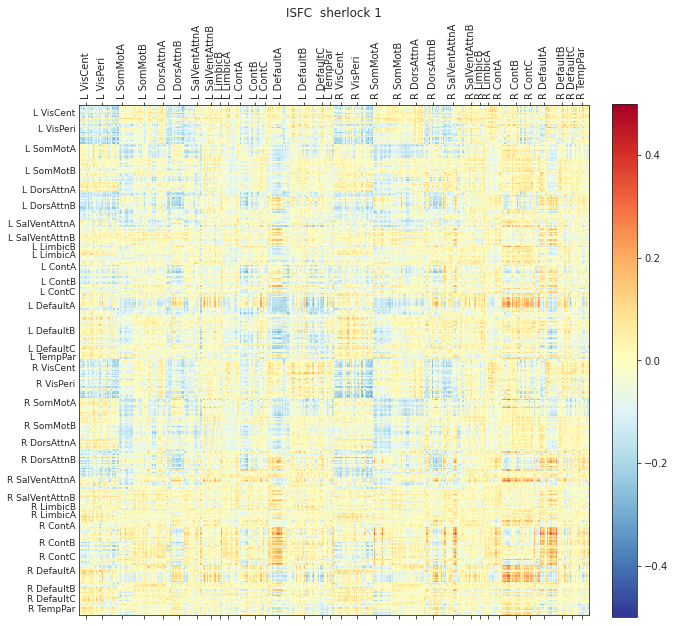

In [59]:
vmin, vmax = -.5, .5
sns.set_style('white')

fig, ax = plt.subplots(figsize=(10, 10))
fc_mat = subtr_isfcs  # Choose the desired FC matrix to plot
fc_title = 'ISFC (subtraction)'  # Set the title accordingly

im = ax.matshow(subtr_isfcs , vmax=vmax, vmin=vmin, cmap='RdYlBu_r')
ax.xaxis.set_label_position('bottom')

# Rotate xtick labels
ax.set_xticks(network_idxs)
ax.set_xticklabels(network_labels, rotation=90)  # Rotate the labels by 90 degrees

ax.set_yticks(network_idxs)
ax.set_yticklabels(network_labels)
ax.tick_params(axis='y', which='both', length=0, labelsize=9)
ax.set_title(f"ISFC  {movie} {run}")

# Add color bar
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.show()

In [209]:
# Check shape of output ISC values
print(f"ISC values shape = {iscs.shape} \ni.e., {iscs.shape[0]} "
      f"left-out subjects and {iscs.shape[1]} voxel(s)")

ISC values shape = (17, 112179) 
i.e., 17 left-out subjects and 112179 voxel(s)


In [210]:
# Compute mean ISC (with Fisher transformation)
mean_iscs = compute_summary_statistic(iscs, summary_statistic='mean', axis=0)

print(f"ISC values shape = {mean_iscs.shape} \ni.e., {mean_iscs.shape[0]} "
      f"mean value across left-out subjects and {iscs.shape[1]} voxel(s)"
      f"\nMinimum mean ISC across voxels = {np.nanmin(mean_iscs):.3f}; "
      f"maximum mean ISC across voxels = {np.nanmax(mean_iscs):.3f}")


# Compute median ISC
median_iscs = compute_summary_statistic(iscs, summary_statistic='median',
                                        axis=0)

print(f"ISC values shape = {median_iscs.shape} \ni.e., {median_iscs.shape[0]} "
      f"median value across left-out subjects and {iscs.shape[1]} voxel(s)"
      f"\nMinimum median ISC across voxels = {np.nanmin(median_iscs):.3f}; "
      f"maximum median ISC across voxels = {np.nanmax(median_iscs):.3f}")

ISC values shape = (112179,) 
i.e., 112179 mean value across left-out subjects and 112179 voxel(s)
Minimum mean ISC across voxels = -0.146; maximum mean ISC across voxels = 0.708
ISC values shape = (112179,) 
i.e., 112179 median value across left-out subjects and 112179 voxel(s)
Minimum median ISC across voxels = -0.168; maximum median ISC across voxels = 0.762


/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/brainiak/isc.py:523: RuntimeWarning: Mean of empty slice
  statistic = np.tanh(np.nanmean(np.arctanh(iscs), axis=axis))
/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


In [211]:
# Run bootstrap hypothesis test on ISCs
n_boot = 200
observed, ci, p, distribution = bootstrap_isc(iscs, pairwise=False,
                                              ci_percentile=95,
                                              summary_statistic='median',
                                              n_bootstraps=n_boot)

In [212]:
# Get number of NaN voxels
n_nans = np.sum(np.isnan(observed))
print(f"{n_nans} voxels out of {observed.shape[0]} are NaNs "
      f"({n_nans / observed.shape[0] * 100:.2f}%)")

# Get voxels without NaNs
nonnan_mask = ~np.isnan(observed)
nonnan_coords = np.where(nonnan_mask)

# Mask both the ISC and p-value map to exclude NaNs
nonnan_isc = observed[nonnan_mask]
nonnan_p = p[nonnan_mask]

3635 voxels out of 112179 are NaNs (3.24%)


In [215]:
# Get FDR-controlled q-values
nonnan_q = multipletests(nonnan_p, method='fdr_by')[1]
threshold = .05
print(f"{np.sum(nonnan_q < threshold)} significant voxels "
      f"controlling FDR at {threshold}")

# Threshold ISCs according FDR-controlled threshold
nonnan_isc[nonnan_q >= threshold] = np.nan

# Reinsert thresholded ISCs back into whole brain image
isc_thresh = np.full(observed.shape, np.nan)
isc_thresh[nonnan_coords] = nonnan_isc

27906 significant voxels controlling FDR at 0.05


In [221]:
# Create empty 3D image and populate
# with thresholded ISC values
isc_img = np.full(ref_nii.shape, np.nan)
isc_img[mask_coords] = isc_thresh

# Convert to NIfTI image
isc_nii = nib.Nifti1Image(isc_img, ref_nii.affine, ref_nii.header)

/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/nilearn/_utils/niimg.py:62: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  "Non-finite values detected. "


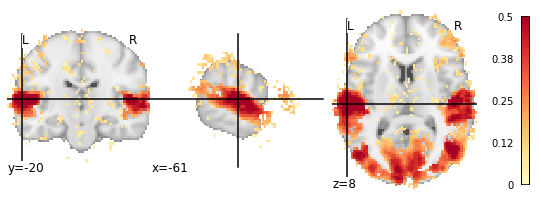

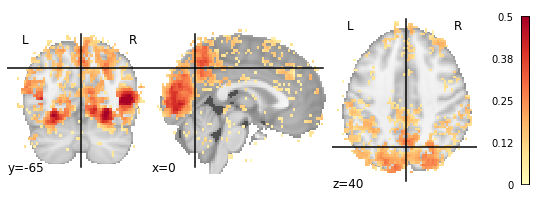

In [224]:
# Plot slices at coordinates -61, -20, 8
plot_stat_map(
    isc_nii,
    cmap='RdYlBu_r',
    vmax=.5,
    cut_coords=(-61, -20, 8))

# Plot slices at coordinates 0, -65, 40
plot_stat_map(
    isc_nii,
    cmap='RdYlBu_r',
    vmax=.5,
    cut_coords=(0, -65, 40))
plt.show()

In [128]:
ext_isc = {}
int_isc = {}

## Reshape output dictionary ## 
for mov in external: 
    print(f'{mov} size is {external[mov].shape}')
    ## set dimensions 3 and Four ## 
    dim_3 = num_repeats
    dim_4 = int(external[mov].shape[2] / num_repeats) # num_odd_subs 
    
    ## Dividing total runs by number of runs should equal the number of subs
    #assert external[mov].shape[2] / num_repeats == num_odd_subs, 'Wrong reshape size!'
    
    # create reshaped dic #
    if key not in ext_isc:
        ext_isc[mov] = external[mov].reshape(*external[mov].shape[:-1], dim_3, dim_4).transpose(0, 1, 3, 2)
    print(np.array_equal(external[mov][:,:,2], ext_isc[mov][:,:,2,0]))
    print(f'reshaped {ext_isc[mov].shape}')

print()

for mov in internal: 
    print(f'INTERNAL:{mov} size is {internal[mov].shape}')
    ## set dimensions 3 and Four ## 
    dim_3 = num_repeats
    dim_4 = int(internal[mov].shape[2] / num_repeats) # num_odd_subs 
    
    ## Dividing total runs by number of runs should equal the number of subs
    #assert external[mov].shape[2] / num_repeats == num_odd_subs, 'Wrong reshape size!'
    
    # create reshaped dic #
    if key not in ext_isc:
        int_isc[mov] = internal[mov].reshape(*internal[mov].shape[:-1], dim_3, dim_4).transpose(0, 1, 3, 2)
    print(np.array_equal(internal[mov][:,:,2], int_isc[mov][:,:,2,0]))
    print(f'reshaped {int_isc[mov].shape}')





office size is (106, 112179, 68)
True
reshaped (106, 112179, 17, 4)
cake size is (103, 112179, 68)
True
reshaped (103, 112179, 17, 4)
brushing size is (92, 112179, 68)
True
reshaped (92, 112179, 17, 4)
shrek size is (94, 112179, 64)
True
reshaped (94, 112179, 16, 4)
sherlock size is (102, 112179, 64)
True
reshaped (102, 112179, 16, 4)
oragami size is (86, 112179, 64)
True
reshaped (86, 112179, 16, 4)


In [ ]:
external['shrek'].shape

In [99]:
external['office'].shape[2] / num_odd_subs

4.0

In [107]:
external['shrek'].shape

(94, 112179, 64)

In [ ]:
"""
oneD.reshape(86, 112179, 4, 5) reshapes oneD into a temporary array with shape (86, 112179, 4, 5).

transpose(0, 1, 3, 2) rearranges the dimensions of the temporary array. The numbers inside the transpose function specify the new order of the dimensions. In this case, the transpose operation is performed as follows:

The first dimension (axis 0) remains unchanged.
The second dimension (axis 1) remains unchanged.
The third dimension (axis 3) becomes the new fourth dimension.
The fourth dimension (axis 2) becomes the new third dimension.
By specifying the order (0, 1, 3, 2) in transpose, the dimensions are rearranged accordingly.

As a result, the temporary array is transformed from (86, 112179, 4, 5) to (86, 112179, 5, 4), matching the desired shape (86, 112179, 4, 5).

The transpose operation allows you to permute the dimensions flexibly, enabling you to rearrange the axes of an array to match your desired shape or to facilitate certain operations on the data.

"""

In [317]:
"""
basicalyy, a simple reshape dosn't properly transpose. we need to rearange the last two dimensions. I'm not entirely 
sure why tho... the coding should be 
"""org = internal['oragami']
org_reshape = org.reshape(86, 112179, 4, 5).transpose(0, 1, 3, 2)
print(np.array_equal(org[:,:,2], org_reshape[:,:,2,0]))

True


In [248]:
for key in internal:
    print(key, internal[key].shape)

oragami (86, 112179, 20)
shrek (94, 112179, 16)
sherlock (102, 112179, 16)
brushing (92, 112179, 8)
cake (103, 112179, 8)
office (106, 112179, 4)


In [269]:
org = internal['oragami']


In [302]:
org = internal['oragami']
print(f'org1 shape: {org.shape}')
org2 = org.reshape(*org.shape[:-1], org.shape[-1] // 5, 5)
print(f'org2 shape: {org2.shape}')
print('first D:', np.unique(org[:,:,0] == org2[:,:,0,0]))
print('second D,', np.unique(org[:,:,1] == org2[:,:,1,0]))

org1 shape: (86, 112179, 20)
org2 shape: (86, 112179, 4, 5)
first D: [ True]
second D, [False  True]


In [31]:
load_epi_data('sub-000',ses="ses-01",task="Attn",run=1, space='MNI'),

(78, 93, 65, 209)
Loading data from /jukebox/graziano/coolCatIsaac/ATM/data/bids/derivatives/fmriprep/sub-000/ses-01/func/sub-000_ses-01_task-Attn_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


(<nibabel.nifti1.Nifti1Image at 0x7fee4757e4d0>,)

## troubleshoot 

In [68]:
sub_list = [
     'sub-003', 'sub-004', 'sub-005','sub-006','sub-007','sub-008','sub-009','sub-010'
    ,'sub-012','sub-013','sub-016','sub-017','sub-018','sub-019','sub-020','sub-021',
    'sub-022','sub-023','sub-024','sub-025','sub-026','sub-027','sub-028','sub-029','sub-030','sub-031','sub-032',
    'sub-033','sub-034','sub-035','sub-036','sub-037','sub-038','sub-039','sub-040'
]

sub_list = ['sub-030','sub-031','sub-032',
    'sub-033','sub-034','sub-035','sub-036','sub-037','sub-038','sub-039','sub-040'
]


sub_list = ['sub-002']

In [87]:
external = {}
internal = {}

for sub in sub_list:
    ### fMRI load ###
    sub_dic_fmri = np.load(f'{preproc_dir}/{sub}_fwhm6_conf.npy', allow_pickle=True).item()
    print(sub)
    
    ## BEHAVIORAL ##
    sub_dic_behav = np.load(os.path.join(behav_dir, f'{sub}_behav.npy'), allow_pickle=True).item()

    # Initialize an empty dictionary to store the stacked arrays for the current subject
    stacked_arrays = {}
    
    # Create subject number 
    sub_num = int(sub[-3:])

    for epi_index in range(0, 6):
        # Add one to the index to create 1-6 runs
        epi_run = epi_index + 1

        # Get the movie name
        mov_name = sub_dic_behav['mov_order'][epi_index]

        # Create an empty array for the movie runs
        mov_runs = np.zeros((mov_len_dic[mov_name] + tr_buffer, voxel_num, 0))

        print(f'movie: {mov_name} with shape {mov_runs.shape}')

        # Get the fMRI run for the current epi_index
        fmri_run = sub_dic_fmri[epi_run]
        
        """
        ## adjust subject 2 ##
        if epi_index == 0 and sub == 'sub-002':
            for i in range(2):
                fmri_run = np.vstack((fmri_run, fmri_run[-1,:]))
        """

                
        print(fmri_run.shape)
        
        # Loop over runs
        for run in range(1, 5):
            # Is this an internal or external run?
            key = 'External' if (sub_num % 2 == 1 and epi_index < 3) or (sub_num % 2 == 0 and epi_index >= 3) else 'Internal'
            
            # Begin slicing #
            start_tr = sub_dic_behav[key][mov_name][f'run-{run:d}']['start_tr']
            end_tr = sub_dic_behav[key][mov_name][f'run-{run:d}']['end_tr']
            run_slice = fmri_run[start_tr:end_tr, :]
            
            # BEHAV checks #
            assert mov_runs.shape[0] == mov_len_dic[mov_name] + tr_buffer, f'behavioral ERROR: movie: {mov_name}, epi {epi_run}, run: {run}'

            # fMRI data check #
            assert run_slice.shape[0] == mov_runs.shape[0], f'fMRI error! {run_slice.shape[0]} verse {mov_runs.shape[0]}'
            

            # Stack the run slice with the mov_runs array
            mov_runs = np.dstack((mov_runs, run_slice))
            print(f'stacked! {mov_runs.shape}')

        # Add an additional dimension for subject stacking
        #mov_runs = np.expand_dims(mov_runs, 3)
        
        # Stack the mov_runs array with the external[mov_name] array
        #stacked_arrays[mov_name] = mov_runs
        
        # set outer loop #
        if key == 'External':
            target_dict = external
        else:
            target_dict = internal

        if mov_name not in target_dict:
            target_dict[mov_name] = mov_runs
        else:
            #mov_runs = np.expand_dims(mov_runs, 3)
            target_dict[mov_name] = np.dstack((target_dict[mov_name], mov_runs))
    print(f'\n subject {sub} finished \n')

            
print('done')
            
            
            
            
            
            

sub-002
movie: shrek with shape (94, 112179, 0)
(390, 112179)
stacked! (94, 112179, 1)
stacked! (94, 112179, 2)
stacked! (94, 112179, 3)
stacked! (94, 112179, 4)
movie: sherlock with shape (102, 112179, 0)
(417, 112179)
stacked! (102, 112179, 1)
stacked! (102, 112179, 2)
stacked! (102, 112179, 3)
stacked! (102, 112179, 4)
movie: oragami with shape (86, 112179, 0)
(355, 112179)
stacked! (86, 112179, 1)
stacked! (86, 112179, 2)
stacked! (86, 112179, 3)
stacked! (86, 112179, 4)
movie: office with shape (106, 112179, 0)
(437, 112179)
stacked! (106, 112179, 1)
stacked! (106, 112179, 2)
stacked! (106, 112179, 3)
stacked! (106, 112179, 4)
movie: cake with shape (103, 112179, 0)
(422, 112179)
stacked! (103, 112179, 1)
stacked! (103, 112179, 2)
stacked! (103, 112179, 3)
stacked! (103, 112179, 4)
movie: brushing with shape (92, 112179, 0)
(379, 112179)
stacked! (92, 112179, 1)
stacked! (92, 112179, 2)
stacked! (92, 112179, 3)
stacked! (92, 112179, 4)

 subject sub-002 finished 

done


In [84]:
x = np.zeros((fmri_run.shape))
if epi_index == 0 and sub == 'sub-002':
    for i in range(2):
        x = np.vstack((x, x[-1,:]))

In [85]:
x.shape

(379, 112179)

In [71]:
mov_runs.shape

(94, 112179, 3)

In [77]:
temp = mov_runs

In [74]:
mov_runs[-1,:,2].shape

(112179,)

In [75]:
run_slice.shape

(92, 112179)

In [76]:
np.vstack((run_slice, fmri_runs[-1,:])).shape

(93, 112179)

In [ ]:
if run == 2 and sub == 'sub-002':
    for i in range(2):
        fmri_run = np.vstack((fmri_run, fmri_runs[-1,:]))
        
        

In [31]:
sub_dic_fmri = np.load(f'{preproc_dir}/{sub}_fwhm6_conf.npy', allow_pickle=True).item()

In [52]:
fmri_run[start_tr:end_tr, :].shape

(11, 112179)

In [44]:
sub_dic_fmri[5].shape

(389, 112179)

In [51]:
fmri_run.shape

(389, 112179)

In [49]:
run_slice.shape

(11, 112179)

In [40]:
mov_name

'shrek'

In [53]:
start_tr

378

In [54]:
end_tr

472

In [ ]:
### BELOW SHOULDN'T BE 94 FOR THE START TR! THAT'S CRAZY! EVERYTHING IS SHIFTED BY 94 ISH? CHECK BEHAVIORAL FOR THIS SUB ## 

In [67]:
sub_dic_behav['External']

{'cake': {'run-1': {'start_tr': 15, 'end_tr': 118, 'bpress': -1},
  'run-2': {'start_tr': 119, 'end_tr': 222, 'bpress': -1},
  'run-3': {'start_tr': 223, 'end_tr': 326, 'bpress': -1},
  'run-4': {'start_tr': 327, 'end_tr': 430, 'bpress': -1}},
 'brushing': {'run-1': {'start_tr': 7, 'end_tr': 99, 'bpress': -1},
  'run-2': {'start_tr': 99, 'end_tr': 191, 'bpress': -1},
  'run-3': {'start_tr': 191, 'end_tr': 283, 'bpress': -1},
  'run-4': {'start_tr': 283, 'end_tr': 375, 'bpress': -1}},
 'office': {'run-1': {'start_tr': 10, 'end_tr': 116, 'bpress': -1},
  'run-2': {'start_tr': 117, 'end_tr': 223, 'bpress': -1},
  'run-3': {'start_tr': 224, 'end_tr': 330, 'bpress': -1},
  'run-4': {'start_tr': 330, 'end_tr': 436, 'bpress': -1}}}

In [73]:
mov_name

'shrek'

In [61]:
fmri_run.shape

(388, 112179)

In [23]:
end_tr - start_tr 

-775

In [62]:
end_tr

390

In [64]:
mov_len_dic[mov_name]

90

In [65]:
mov_runs.shape[0]

94

In [36]:
mov_len_dic

{'oragami': 82,
 'shrek': 90,
 'sherlock': 98,
 'brushing': 88,
 'cake': 99,
 'office': 102}